# Data loading and feature extraction

#### Load Karpathy split and organize the COCO data according to it

In [ ]:
import json
import pandas as pd
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from tqdm import tqdm
from PIL import Image
import numpy as np
import os


karpathy_file = '/kaggle/input/karpathy-splits/dataset_coco.json'

if not os.path.exists(karpathy_file):
    raise FileNotFoundError(f"Karpathy split not found at: {karpathy_file}")

with open(karpathy_file, 'r') as f:
    karpathy_data = json.load(f)


def organize_by_split(karpathy_data):
    splits = {'train': [], 'val': [], 'test': []}
    
    for img_data in karpathy_data['images']:
        split = img_data['split']
        
        # handle 'restval' - we add them to the training set 
        if split == 'restval':
            split = 'train'
        
        if split in ['train', 'val', 'test']:
          
            image_info = {
                'image_id': img_data['cocoid'],
                'file_name': img_data['filename'],  
                'captions': [sent['raw'] for sent in img_data['sentences']]
            }
            splits[split].append(image_info)
    
    return splits

splits_data = organize_by_split(karpathy_data)

# convert to DataFrames
train_df = pd.DataFrame(splits_data['train'])
val_df = pd.DataFrame(splits_data['val'])
test_df = pd.DataFrame(splits_data['test'])
print(train_df.head())

Load the pretrained feature extractor models

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device: {device}")

# VGG16 - fc7 features (4096-dim) - matching the paper

vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
vgg16.classifier = vgg16.classifier[:-1]  # remove last layer to get fc7
vgg16 = vgg16.to(device)
vgg16.eval()

# ResNet101

resnet101 = models.resnet101(weights=models.ResNet101_Weights.IMAGENET1K_V1)
resnet101 = torch.nn.Sequential(*list(resnet101.children())[:-1])  # remove FC layer
resnet101 = resnet101.to(device)
resnet101.eval()

## Feature extraction

In [ ]:
# image preprocessing
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])


def extract_features(image_path, model):
    try:
        img = Image.open(image_path).convert('RGB')
        img = transform(img).unsqueeze(0).to(device)
        
        with torch.no_grad():
            features = model(img)
            if len(features.shape) > 2:
                features = features.squeeze()
        
        return features.cpu().numpy()
    except Exception as e:
        return None


def get_image_path(filename, base_paths):   
    # determine which folder based on filename
    if 'train2014' in filename:
        folder = 'train2014'
    elif 'val2014' in filename:
        folder = 'val2014'
    else:
        return None
    
    img_path = f"{base_paths[folder]}/{filename}"
    
    if os.path.exists(img_path):
        return img_path
    else:
        return None



def extract_and_save_split_features(df, split_name, base_paths, models_dict):
   
    features_by_model = {model_name: {} for model_name in models_dict.keys()}
    missing_images = []
    processed = 0
    
    for idx, row in tqdm(df.iterrows(), total=len(df), desc=f"{split_name}"):
        img_id = row['image_id']
        img_filename = row['file_name']
        
        img_path = get_image_path(img_filename, base_paths)
        
        if img_path is None:
            missing_images.append(img_filename)
            continue
        
        # extract features with each model
        for model_name, model in models_dict.items():
            features = extract_features(img_path, model)
            if features is not None:
                features_by_model[model_name][img_id] = features
        
        processed += 1
    

BASE_PATHS = {
    'train2014': '/kaggle/input/coco2014/train2014/train2014',
    'val2014': '/kaggle/input/coco2014/val2014/val2014'
}


models_dict = {
    'vgg16': vgg16,
    'resnet101': resnet101,
}

#start feature extraction
train_features = extract_and_save_split_features(train_df, 'train', BASE_PATHS, models_dict)
val_features = extract_and_save_split_features(val_df, 'val', BASE_PATHS, models_dict)
test_features = extract_and_save_split_features(test_df, 'test', BASE_PATHS, models_dict)

Save the caption metadata

In [ ]:
train_df.to_pickle('train_captions.pkl')
val_df.to_pickle('val_captions.pkl')
test_df.to_pickle('test_captions.pkl')

train_df.to_csv('train_captions.csv', index=False)
val_df.to_csv('val_captions.csv', index=False)
test_df.to_csv('test_captions.csv', index=False)

# Vocabulary


In [12]:
import pandas as pd
import numpy as np
import pickle
import re
from collections import Counter
from tqdm import tqdm


# vocabulary size  ~9,221 words + special tokens ( matches the paper's approach)

class Vocabulary:
    
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.word_counts = Counter()
        
        # special tokens
        self.PAD_TOKEN = '<PAD>'
        self.START_TOKEN = '<START>'
        self.END_TOKEN = '<END>'
        self.UNK_TOKEN = '<UNK>'
        
        # initialize with special tokens
        self.word2idx = {
            self.PAD_TOKEN: 0,
            self.START_TOKEN: 1,
            self.END_TOKEN: 2,
            self.UNK_TOKEN: 3
        }
        self.idx2word = {v: k for k, v in self.word2idx.items()}
        self.idx = 4  # next available index
    
    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1
    
    def __len__(self):
        return len(self.word2idx)
    
    def __call__(self, word):
        return self.word2idx.get(word, self.word2idx[self.UNK_TOKEN])


def tokenize_caption(caption):
    """
    - Convert to lowercase
    - Remove punctuation (except hyphens in words)
    - Split into words

    """
    caption = caption.lower()
    
    # keeps alphanumeric, apostrophes, and hyphens
    caption = re.sub(r'[^\w\s\'-]', ' ', caption)
    
    # split and remove extra whitespace
    tokens = caption.split()
    
    # remove empty strings
    tokens = [t for t in tokens if t]
    
    return tokens


def build_vocabulary(train_captions_df, vocab_size=9221, min_word_freq=5):
    
    vocab = Vocabulary()
    
    # count all words in training captions
    all_tokens = []
    
    for idx, row in tqdm(train_captions_df.iterrows(), 
                         total=len(train_captions_df),
                         desc="Processing"):
        captions = row['captions']

        #process captions
        for caption in captions:
            tokens = tokenize_caption(caption)
            all_tokens.extend(tokens)
            vocab.word_counts.update(tokens)
    

    # filter by minimum frequency
    filtered_words = {word: count for word, count in vocab.word_counts.items() 
                      if count >= min_word_freq}
    

    most_common = sorted(filtered_words.items(), key=lambda x: x[1], reverse=True)
    
    # vocab_size - 4 (to account for special tokens)
    top_words = most_common[:vocab_size - 4]
    
    for word, count in tqdm(top_words, desc="Adding words"):
        vocab.add_word(word)
    
    return vocab


def save_vocabulary(vocab, filepath='vocabulary.pkl'):
    with open(filepath, 'wb') as f:
        pickle.dump(vocab, f)


def load_vocabulary(filepath='vocabulary.pkl'):
    with open(filepath, 'rb') as f:
        vocab = pickle.load(f)

    return vocab




# load training captions
train_df = pd.read_pickle('train_captions.pkl')

vocab = build_vocabulary(
    train_df, 
    vocab_size=9221,  
    min_word_freq=5  
)

save_vocabulary(vocab, 'vocabulary.pkl')

Adding words: 100%|██████████| 9217/9217 [00:00<00:00, 2005649.80it/s]


# Dataset and DataLoaders

Dataset Objects

In [13]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import pickle
import random
from typing import Tuple, List


class CaptionDataset(Dataset):
    """
    dataset for image captioning that loads pre-extracted features and captions.
    
    Args:
        captions_df: DataFrame with columns ['image_id', 'file_name', 'captions']
        features_dict: Dictionary mapping image_id -> feature vector 
        vocabulary: Vocabulary object
        max_length: Maximum caption length (default: 15, matching paper)
        training: If True, randomly sample one caption per image per epoch
    """
    
    def __init__(self, 
                 captions_df: pd.DataFrame,
                 features_dict: dict,
                 vocabulary,
                 max_length: int = 15,
                 training: bool = True):
        
        self.captions_df = captions_df.reset_index(drop=True)
        self.features_dict = features_dict
        self.vocab = vocabulary
        self.max_length = max_length
        self.training = training
        self.valid_indices = []
        for idx, row in self.captions_df.iterrows():
            if row['image_id'] in self.features_dict:
                self.valid_indices.append(idx)

        
    
    def __len__(self):
        return len(self.valid_indices)
    
    def tokenize_caption(self, caption: str) -> List[str]:
        
        import re
        caption = caption.lower()
        caption = re.sub(r'[^\w\s\'-]', ' ', caption)
        tokens = caption.split()
        tokens = [t for t in tokens if t]
        return tokens
    
    def caption_to_sequence(self, caption: str) -> Tuple[torch.Tensor, int]:
        """
        Convert caption to sequence of word indices with <START> and <END>. Pad to max length using <PAD>
        """
        
        words = self.tokenize_caption(caption)
        
        # leave room for START and END
        if len(words) > self.max_length:
            words = words[:self.max_length]
        
        # convert to indices and add START + END
        tokens = [self.vocab.word2idx[self.vocab.START_TOKEN]]
        tokens.extend([self.vocab(word) for word in words])
        tokens.append(self.vocab.word2idx[self.vocab.END_TOKEN])
        
        actual_length = len(tokens)
        
        # pad to max_length + 2 (for START and END)
        max_seq_len = self.max_length + 2
        if len(tokens) < max_seq_len:
            tokens.extend([self.vocab.word2idx[self.vocab.PAD_TOKEN]] * (max_seq_len - len(tokens)))
        
        return torch.tensor(tokens, dtype=torch.long), actual_length
    
    def __getitem__(self, idx):
        """
        returns:
            image_features: Tensor of shape (feature_dim,) - e.g., (4096,) for VGG16
            caption: Tensor of shape (max_length + 2,) - padded caption sequence
            caption_length: int - actual caption length including START/END
        """
        df_idx = self.valid_indices[idx]
        row = self.captions_df.iloc[df_idx]
        
        # Get image features
        image_id = row['image_id']
        image_features = self.features_dict[image_id]
        image_features = torch.from_numpy(image_features).float()
        
        # get caption
        captions = row['captions']
        if self.training:
            caption = random.choice(captions)
        else:
            caption = captions[0]
        
        # Convert caption to sequence
        caption_seq, caption_length = self.caption_to_sequence(caption)
        
        return image_features, caption_seq, caption_length


class CaptionDatasetAllCaptions(Dataset):
    """
    dataset that returns all captions for each image.
    
    Args:
        captions_df: DataFrame with columns ['image_id', 'file_name', 'captions']
        features_dict: Dictionary mapping image_id -> feature vector
        vocabulary: Vocabulary object
        max_length: Maximum caption length
    """
    
    def __init__(self, 
                 captions_df: pd.DataFrame,
                 features_dict: dict,
                 vocabulary,
                 max_length: int = 15):
        
        self.captions_df = captions_df.reset_index(drop=True)
        self.features_dict = features_dict
        self.vocab = vocabulary
        self.max_length = max_length
        
        # create expanded dataset with one entry per caption
        self.data = []
        for idx, row in self.captions_df.iterrows():
            if row['image_id'] in self.features_dict:
                for caption in row['captions']:
                    self.data.append({
                        'image_id': row['image_id'],
                        'caption': caption,
                        'all_captions': row['captions']
                    })
        

    
    def tokenize_caption(self, caption: str) -> List[str]:
        import re
        caption = caption.lower()
        caption = re.sub(r'[^\w\s\'-]', ' ', caption)
        tokens = caption.split()
        tokens = [t for t in tokens if t]
        return tokens
    
    def caption_to_sequence(self, caption: str) -> Tuple[torch.Tensor, int]:
        words = self.tokenize_caption(caption)
        if len(words) > self.max_length:
            words = words[:self.max_length]
        
        tokens = [self.vocab.word2idx[self.vocab.START_TOKEN]]
        tokens.extend([self.vocab(word) for word in words])
        tokens.append(self.vocab.word2idx[self.vocab.END_TOKEN])
        
        actual_length = len(tokens)
        max_seq_len = self.max_length + 2
        
        if len(tokens) < max_seq_len:
            tokens.extend([self.vocab.word2idx[self.vocab.PAD_TOKEN]] * (max_seq_len - len(tokens)))
        
        return torch.tensor(tokens, dtype=torch.long), actual_length
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        
        image_features = self.features_dict[item['image_id']]
        image_features = torch.from_numpy(image_features).float()
        
        # convert caption to sequence
        caption_seq, caption_length = self.caption_to_sequence(item['caption'])
        
        return image_features, caption_seq, caption_length, item['all_captions']

## Helper functions and main dataloader entrypoint

In [14]:
def collate_fn(batch):
    """
    Custom collate function for batching.
    
    Args:
        batch: List of (image_features, caption, length) tuples
    
    Returns:
        images: Tensor of shape (batch_size, feature_dim)
        captions: Tensor of shape (batch_size, max_length + 2)
        lengths: Tensor of shape (batch_size,)
    """
    # Separate the components
    images, captions, lengths = zip(*batch)
    
    # Stack into tensors
    images = torch.stack(images, dim=0)
    captions = torch.stack(captions, dim=0)
    lengths = torch.tensor(lengths, dtype=torch.long)
    
    return images, captions, lengths


def collate_fn_eval(batch):
    """
    Custom collate function for evaluation (includes all reference captions).
    
    Returns:
        images: Tensor of shape (batch_size, feature_dim)
        captions: Tensor of shape (batch_size, max_length + 2)
        lengths: Tensor of shape (batch_size,)
        all_captions: List of lists of reference captions
    """
    images, captions, lengths, all_captions = zip(*batch)
    
    images = torch.stack(images, dim=0)
    captions = torch.stack(captions, dim=0)
    lengths = torch.tensor(lengths, dtype=torch.long)
    
    return images, captions, lengths, list(all_captions)


def create_dataloaders(
    train_df: pd.DataFrame,
    val_df: pd.DataFrame,
    test_df: pd.DataFrame,
    train_features: dict,
    val_features: dict,
    test_features: dict,
    vocabulary,
    batch_size: int = 64,
    max_length: int = 15,
    num_workers: int = 4,
    shuffle_train: bool = True
):
    """
    Create train, validation, and test dataloaders.
    
    Args:
        train_df, val_df, test_df: DataFrames with captions
        train_features, val_features, test_features: Feature dictionaries
        vocabulary: Vocabulary object
        batch_size: Batch size for training
        max_length: Maximum caption length
        num_workers: Number of worker processes for data loading
        shuffle_train: Whether to shuffle training data
    
    Returns:
        train_loader, val_loader, test_loader
    """
  
    # create datasets
    train_dataset = CaptionDataset(
        train_df, 
        train_features, 
        vocabulary, 
        max_length=max_length,
        training=True
    )
    
    val_dataset = CaptionDataset(
        val_df, 
        val_features, 
        vocabulary, 
        max_length=max_length,
        training=False
    )
    
    test_dataset = CaptionDataset(
        test_df, 
        test_features, 
        vocabulary, 
        max_length=max_length,
        training=False
    )
    
    # create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle= shuffle_train,
        num_workers=num_workers,
        collate_fn=collate_fn,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=collate_fn,
        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=collate_fn,
        pin_memory=True
    )
    
    print(f"\nDataLoader Configuration:")
    print(f"  Batch size: {batch_size}")
    print(f"  Num workers: {num_workers}")
    print(f"  Max caption length: {max_length}")
    
    print(f"\nDataLoader Sizes:")
    print(f"  Train batches: {len(train_loader)}")
    print(f"  Val batches: {len(val_loader)}")
    print(f"  Test batches: {len(test_loader)}")
    
    return train_loader, val_loader, test_loader


# Decoder-Transformer Implementation

In [15]:
import torch.nn as nn
import torch.nn.functional as F
import math



class ImageCaptioningTransformer(nn.Module):
 
    def __init__(self, vocab_size, embed_dim=512, num_heads=8, 
                 num_layers=4, image_feat_dim=4096, max_len=17,dropout=0.1):
        super().__init__()
        
        self.embed_dim = embed_dim
        self.max_len = max_len
        self.vocab_size = vocab_size
        
        self.image_embed = nn.Sequential(
            nn.Linear(image_feat_dim, embed_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        self.word_embed = nn.Embedding(vocab_size, embed_dim)
        self.positional_embed = nn.Embedding(max_len+1, embed_dim) # +1 for the image

        self.embed_dropout = nn.Dropout(dropout)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=2048,
            dropout=dropout,
            activation='relu',
            batch_first=True, 
            norm_first=False  
        )

        self.transformer = nn.TransformerEncoder(
            encoder_layer=encoder_layer,
            num_layers = num_layers
        )
        
        self.output_project= nn.Linear(embed_dim, vocab_size)
        

    def generate_causal_mask(self, seq_len, device):
        """
        Generate causal mask: upper triangular matrix of -inf.
        
        """
        mask = torch.triu(
            torch.ones(seq_len, seq_len, device=device) * float('-inf'),
            diagonal=1
        )
        return mask
    
    def generate_padding_mask(self,captions,pad_idx=0):
        return (captions == pad_idx)
        
    def forward(self,images,captions):
        """
        forward pass
        """
        if images.dim()==3:
            images = images.squeeze(1)
        device = captions.device
        batch_size, seq_len = captions.shape

        img_embed = self.image_embed(images).unsqueeze(1) # -> (batch, 1,512)

        caption_embed = self.word_embed(captions)

        sequence = torch.cat([img_embed,caption_embed], dim = 1)

        positional_encoding = torch.arange(seq_len + 1,device=device).unsqueeze(0)
        positional_encoding= self.positional_embed(positional_encoding)

        sequence = sequence + positional_encoding
        sequence = self.embed_dropout(sequence)
        
        causal_mask = self.generate_causal_mask(seq_len +1, device)
        padding_mask = self.generate_padding_mask(captions)

        img_padding_mask = torch.zeros(batch_size,1, dtype=bool, device=device)

        padding_mask = torch.cat([img_padding_mask, padding_mask], dim = 1)

        output = self.transformer(
            sequence,
            mask=causal_mask,          
            src_key_padding_mask=padding_mask
        )

        logits = self.output_project(output)
        
        return logits


    def generate(self,images, start_token_idx=1, end_token_idx =2):
        """
        Generate captions autoregressively
        
        Start with [START]
        Loop:
          1. Get predictions for current sequence
          2. Take last prediction
          3. Sample/argmax next token
          4. Append to sequence
          5. Stop if END token or max_len reached
        """
        self.eval()
        batch_size = images.shape[0]
        device = images.device
        generated = torch.full((batch_size,1), start_token_idx,dtype= torch.long, device=device)

        # track what sequences have finished
        finished = torch.zeros(batch_size, dtype=torch.bool, device=device)
        with torch.no_grad():
            for _ in range(self.max_len):
                logits = self.forward(images, generated)

                next_logits = logits[:,-1,:]
                next_token = next_logits.argmax(dim=1,keepdim = True)

                generated = torch.cat([generated, next_token], dim = 1)

                finished = finished | (next_token.squeeze(-1) == end_token_idx)

                # stop if all sequences have finished
                if finished.all():
                    break

        return generated
    


## Loss function and padding mask

In [16]:
class MaskedCrossEntropyLoss(nn.Module):
    def __init__(self,pad_idx=0):
        super().__init__()
        self.pad_idx = pad_idx
        self.criterion = nn.CrossEntropyLoss(reduction='none')

    def forward(self, logits, targets):
        """
        logits (batch,seq_len,vocab_size)
        targets (batch, seq_len, 1)
        """
        batch_size,seq_len, vocab_size = logits.shape
        device = logits.device
        
        logits_flat = logits.reshape(-1,vocab_size) # ( batch * seq_len, vocab_size)
        targets_flat = targets.reshape(-1)  # (batch * seq_len)

        
        loss = self.criterion(logits_flat, targets_flat)

        mask = (targets_flat != self.pad_idx).float()

        loss_masked = loss * mask

        return torch.sum(loss_masked) / torch.sum(mask)
        

## Train step and validation

In [17]:

def train_step(model, images, captions, lengths, criterion, optimizer, device):
    """
    One training step with teacher forcing
    
    Remember:
      - Input to model: captions
      - Model output: logits at each position
      - Predictions: logits[:, :-1, :] (drop last)
      - Targets: captions (original)
    """

    model.train()
    # Move to gpu
    images = images.to(device)
    captions = captions.to(device)
    lengths = lengths.to(device)
    logits = model(images,captions) # we pass ground truth for "teacher forcing"
    
    logits = logits[:,:-1,:]

    loss = criterion(logits, captions)

    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    
    # Gradient clipping (prevent exploding gradients)
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
    
    optimizer.step()
    
    return loss.item()


def validate(model, val_loader, criterion, device):
    """
    Validation loop.
    
    Args:
        model: ImageCaptioningTransformer model
        val_loader: validation DataLoader
        criterion: MaskedCrossEntropyLoss
        device: device to run on
    
    Returns:
        avg_loss: average validation loss
    """
    model.eval()
    total_loss = 0
    num_batches = 0
    
    with torch.no_grad():
        for images, captions, lengths in val_loader:
            images = images.to(device)
            captions = captions.to(device)
            lengths = lengths.to(device)
            
            # forward pass
            logits = model(images, captions)
            
            # compute loss 
            predictions = logits[:, :-1, :]
            targets = captions
            
            loss = criterion(predictions, targets)
            
            total_loss += loss.item()
            num_batches += 1
    
    return total_loss / num_batches

# Training

In [18]:
def train_epoch(model, criterion, train_loader,optimizer,config,epoch):
    model.train()

    total_loss = 0
    num_batches =0

    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{config.num_epochs}')
    for batch_idx, (images,captions,lengths) in enumerate(pbar):
       
        loss = train_step(model, images, captions, lengths, 
                         criterion, optimizer, config.device)
        
        total_loss+=loss
        num_batches+=1

    return total_loss/ num_batches



In [36]:
class Config:
    """
    training configuration
    """
   # model
    vocab_size = 9221
    embed_dim = 512
    num_heads = 8
    num_layers = 4
    image_feat_dim = 4096
    max_len = 17
    dropout = 0.1
    
    # training
    batch_size = 128
    num_epochs = 70
    learning_rate = 5e-5
    weight_decay = 1e-4
    base_dir ="/kaggle/working"
    save_dir="checkpoints"
    save_every= 10 
    print_every=10
    
    
    # device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    

def plot_training_history(train_losses=None,val_losses =None):

    if train_losses is None or val_losses is None:
        history_path = os.path.join(config.base_dir, config.save_dir, 'training_history.pkl')
        
        history = pd.read_pickle(history_path)
        
        train_losses = history['train_losses']
        val_losses = history['val_losses']

    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    
    plt.title('Training and Validation Loss per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.show()
        
import time
import os
def train(config):
    """
    -. we need to call the train_step function for n epochs for all batches
    - 
    
    """
    train_df = pd.read_pickle('train_captions.pkl')
    val_df = pd.read_pickle('val_captions.pkl')

    train_features = np.load('coco_train_vgg16_features.npy', allow_pickle=True).item()
    val_features = np.load('coco_val_vgg16_features.npy',allow_pickle = True).item()
    
    vocab = build_vocabulary(train_df,config.vocab_size)
    
    train_loader, val_loader, _ = create_dataloaders(# test_features and test_df are not used during training, so i used val_df as a dummy
        train_df,val_df,val_df,train_features,val_features,val_features,vocab,config.batch_size
    )

    model = ImageCaptioningTransformer(config.vocab_size, 
                                       config.embed_dim,
                                       config.num_heads,
                                       config.num_layers, 
                                       config.image_feat_dim,
                                       config.max_len,
                                       config.dropout
                                      ).to(config.device)
    

    optimizer = torch.optim.RMSprop(model.parameters(), 
                                    lr=config.learning_rate)
    
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=config.num_epochs
    )

    criterion = MaskedCrossEntropyLoss()
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []

    os.makedirs(os.path.join(config.base_dir, config.save_dir),exist_ok=True)
    
    for epoch in range(config.num_epochs):
        epoch_start= time.time()
        
        train_loss = train_epoch(model, criterion, train_loader,optimizer,config,epoch)
        train_losses.append(train_loss)

        val_loss = validate(model,val_loader,criterion,config.device)
        val_losses.append(val_loss)
        
        scheduler.step()

        epoch_time = time.time() - epoch_start

        if (epoch +1) % config.save_every ==0:
            checkpoint_path = os.path.join(
                config.base_dir,
                config.save_dir,
                f'checkpoint_epoch_{epoch+1}.pt'
            )
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
                'config': config
            }, checkpoint_path)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            checkpoint_path = os.path.join(
                config.base_dir,
                config.save_dir,
                f'best_model.pt'
            )
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
                'config': config
            }, checkpoint_path)
        if (epoch +1 ) % config.print_every ==0:
            print_training_history(train_losses,val_losses)
            print(f"Epoch {epoch+1}: train_loss = {train_loss} ; val_loss = {val_loss}")
        
    history = {
        'train_losses': train_losses,
        'val_losses': val_losses
    }
    
    history_path = os.path.join(config.base_dir,config.save_dir, 'training_history.pkl')
    with open(history_path, 'wb') as f:
        pickle.dump(history, f)
        
    print("Training history saved")


# Main

In [37]:
config=Config()
train(config)

Adding words: 100%|██████████| 9217/9217 [00:00<00:00, 1810721.31it/s]



DataLoader Configuration:
  Batch size: 128
  Num workers: 4
  Max caption length: 15

DataLoader Sizes:
  Train batches: 886
  Val batches: 40
  Test batches: 40


Epoch 1/70:   0%|          | 0/886 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6041: UserWarning: Support for mismatched src_key_padding_mask and mask is deprecated. Use same type for both instead.
  warnings.warn(
Epoch 70/70: 100%|██████████| 886/886 [00:48<00:00, 18.22it/s]


Training history saved


# Visualizing results

In [39]:

def indices_to_caption(indices, idx2word):
    """
    Convert token indices to text caption.
    
    Args:
        indices: Tensor of shape (seq_len,)
        idx2word: Dictionary mapping indices to words
    
    Returns:
        caption: String caption
    """
    special_tokens = {'<START>', '<END>', '<PAD>', '<UNK>'}
    
    # Convert to numpy if needed
    if torch.is_tensor(indices):
        indices = indices.cpu().numpy()
    
    words = []
    for idx in indices:
        idx = int(idx)
        word = idx2word.get(idx, '<UNK>')
        
        # Stop at <END> token
        if word == '<END>':
            break
        
        # Skip special tokens
        if word in special_tokens:
            continue
        
        words.append(word)
    
    return ' '.join(words)


from PIL import Image
import matplotlib.pyplot as plt
def visualize_predictions(model, val_df, val_features, vocab, config, num_images=20, seed=42):
    """
    Visualize model predictions on validation images.
    
    Args:
        model: Trained ImageCaptioningTransformer model
        val_df: Validation DataFrame with captions
        val_features: Dictionary of pre-extracted features
        vocab: Vocabulary object
        config: Configuration object
        num_images: Number of images to visualize
        seed: Random seed for reproducibility
    """
    random.seed(seed)
    model.eval()
    device = config.device
    
    # Get reverse vocabulary (index -> word)
    idx2word = vocab.idx2word
    
    # Base paths for images
    BASE_PATHS = {
        'train2014': '/kaggle/input/coco2014/train2014/train2014',
        'val2014': '/kaggle/input/coco2014/val2014/val2014'
    }
    
    # Filter to images that have features
    valid_rows = val_df[val_df['image_id'].isin(val_features.keys())].reset_index(drop=True)
    
    # Randomly sample images
    sample_indices = random.sample(range(len(valid_rows)), min(num_images, len(valid_rows)))
    
    # Create figure
    fig, axes = plt.subplots(5, 4, figsize=(20, 25))
    axes = axes.flatten()
    
    for idx, sample_idx in enumerate(sample_indices):
        row = valid_rows.iloc[sample_idx]
        image_id = row['image_id']
        filename = row['file_name']
        gt_captions = row['captions']
        
        # Get image path
        if 'train2014' in filename:
            img_path = f"{BASE_PATHS['train2014']}/{filename}"
        else:
            img_path = f"{BASE_PATHS['val2014']}/{filename}"
        
        # Load image for display
        try:
            img = Image.open(img_path).convert('RGB')
        except:
            continue
        
        # Get features and generate caption
        features = val_features[image_id]
        features_tensor = torch.from_numpy(features).float().unsqueeze(0).to(device)
        
        # Generate caption
        with torch.no_grad():
            generated_indices = model.generate(
                features_tensor, 
                start_token_idx=vocab.word2idx[vocab.START_TOKEN],
                end_token_idx=vocab.word2idx[vocab.END_TOKEN]
            )
        
        # Convert indices to words
        generated_caption = indices_to_caption(generated_indices[0], idx2word)
        
        # Display image and captions
        axes[idx].imshow(img)
        axes[idx].axis('off')
        
        # Format title with predicted and ground truth captions
        title = f"PREDICTED: {generated_caption}\n\nGROUND TRUTH: {gt_captions[0]}"
        axes[idx].set_title(title, fontsize=8, wrap=True)
    
    plt.tight_layout()
    plt.savefig('predictions_visualization.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    return fig


##

In [41]:
def visualize(config):
    checkpoint_path = os.path.join(
                    config.base_dir,
                    "checkpoints",
                    f'best_model.pt'
                )
    checkpoint = torch.load(checkpoint_path, map_location=config.device, weights_only= False)
    best_model = ImageCaptioningTransformer(config.vocab_size, 
                                           config.embed_dim,
                                           config.num_heads,
                                           config.num_layers, 
                                           config.image_feat_dim,
                                           config.max_len,
                                           config.dropout).to(config.device)
    best_model.load_state_dict(checkpoint['model_state_dict'])
    
    val_df = pd.read_pickle('val_captions.pkl')
    
    val_features = np.load('coco_val_vgg16_features.npy',allow_pickle = True).item()
    
    vocab =pd.read_pickle("vocabulary.pkl")

    visualize_predictions(best_model,val_df,val_features,vocab,config)


/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6041: UserWarning: Support for mismatched src_key_padding_mask and mask is deprecated. Use same type for both instead.
  warnings.warn(


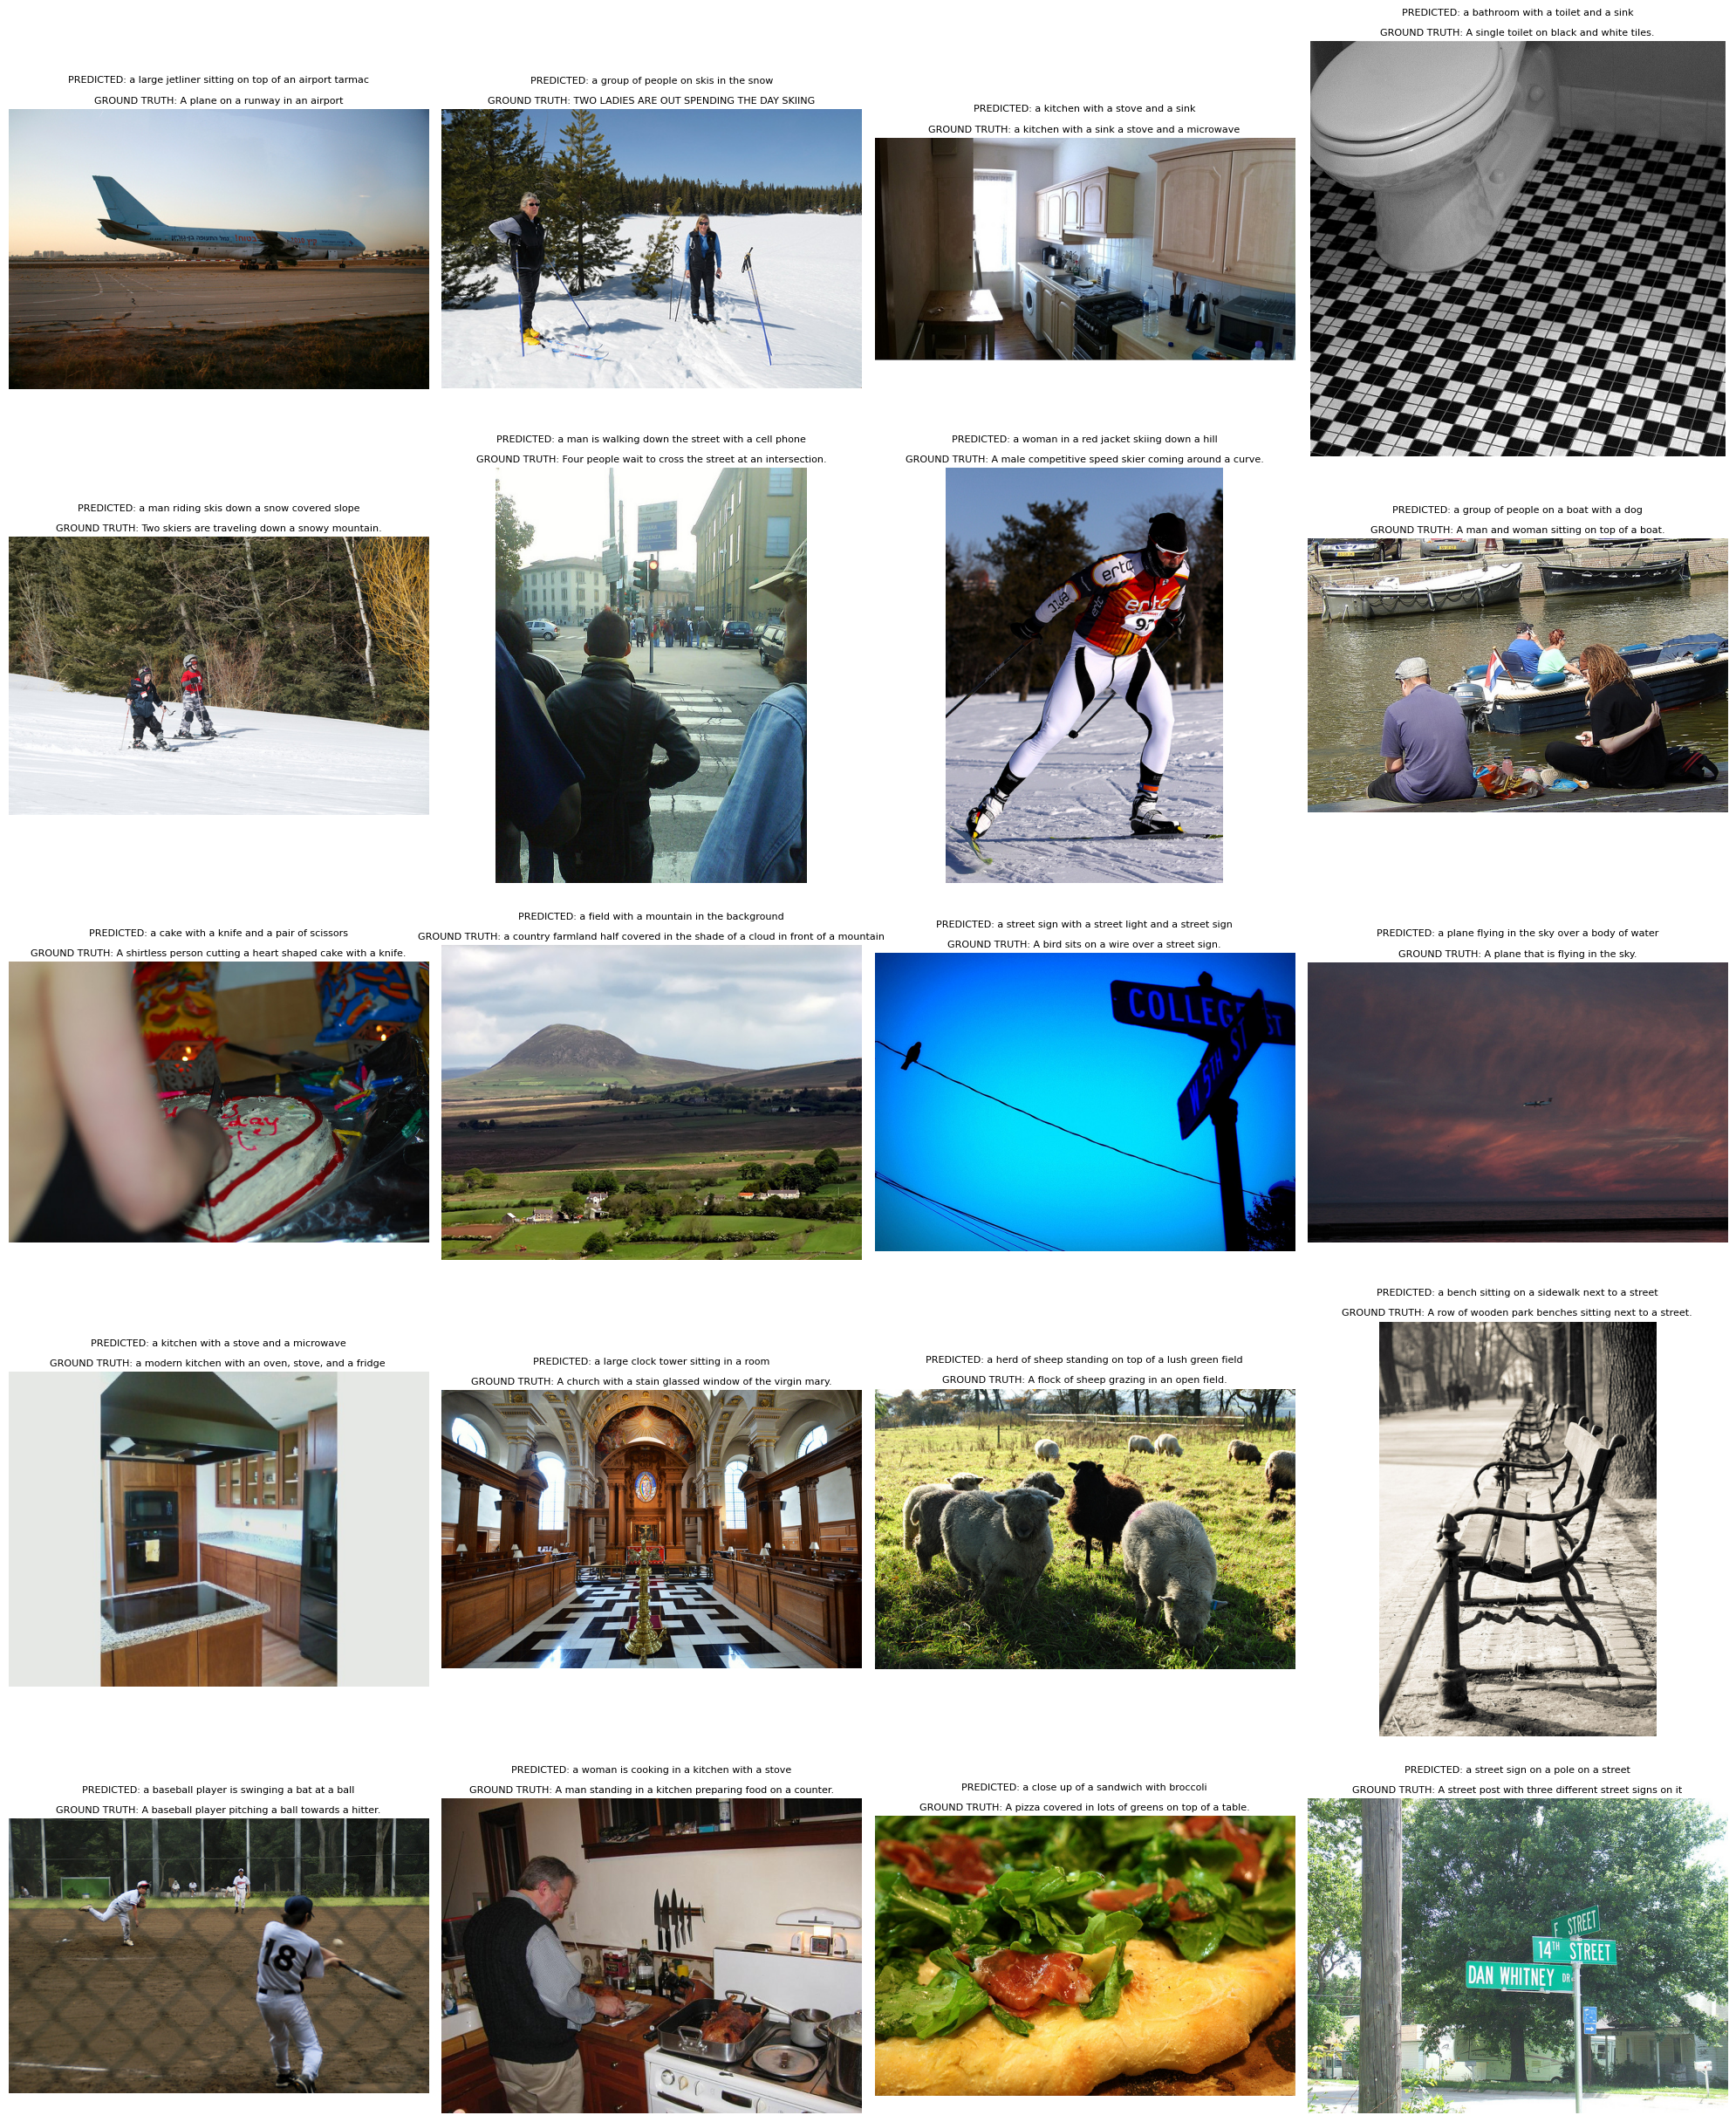

In [42]:
visualize(config)

# Evalution using COCO evaluation tool

In [ ]:
def generate_predictions_simple(model, dataloader, captions_df, max_length=20):
    """
    Simpler version - rebuild image_id mapping from DataFrame
    """
    vocab = pd.read_pickle("/kaggle/working/vocabulary.pkl")
    idx2word = {idx: word for word, idx in vocab.word2idx.items()}# index to word dictionary
    
    # Get valid image_ids in the same order as dataset
    valid_image_ids = []
    dataset = dataloader.dataset
    for df_idx in dataset.valid_indices:
        valid_image_ids.append(captions_df.iloc[df_idx]['image_id'])
    
    model.eval()
    device = next(model.parameters()).device
    predictions = []
    
    pbar = tqdm(dataloader, desc='Generating predictions')
    
    with torch.no_grad():
        sample_idx = 0  # Track which sample we're on
        
        for images, captions, lengths in pbar:
            images = images.to(device)
            generated_indices = model.generate(images, max_length=max_length)
            batch_predictions = indices_to_captions(generated_indices, idx2word, True)
            
            for caption in batch_predictions:
                predictions.append({
                    'image_id': int(valid_image_ids[sample_idx]),
                    'caption': caption
                })
                sample_idx += 1

    
    return predictions,valid_image_ids


# method for data in batches 
def indices_to_captions(indices_batch, idx2word, remove_special_tokens=True):
    """
    Convert batch of token indices to text captions.
    
    Args:
        indices_batch: Tensor of shape (batch_size, seq_len)
        idx2word: Dictionary mapping indices to words
        remove_special_tokens: Whether to remove <START>, <END>, <PAD>
    
    Returns:

        captions: List of string captions
    """
    captions = []
    special_tokens = {'<START>', '<END>', '<PAD>', '<UNK>'}
    
    # Convert to numpy if needed
    if torch.is_tensor(indices_batch):
        indices_batch = indices_batch.cpu().numpy()
    
    for indices in indices_batch:
        words = []
        for idx in indices:
            idx = int(idx)
            word = idx2word.get(idx, '<UNK>')
            
            # Stop at <END> token
            if word == '<END>':
                break
            

            # Skip special tokens if requested
            if remove_special_tokens and word in special_tokens:
                continue
            
            words.append(word)
        
        caption = ' '.join(words)
        captions.append(caption)
    
    return captions


In [43]:
!pip install pycocoevalcap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 18.4 MB/s eta 0:00:0000:0100:01


In [44]:
import json
import os
from collections import defaultdict
import pandas as pd
import torch
from tqdm import tqdm
import numpy as np
from pycocoevalcap.eval import COCOEvalCap
from pycocotools.coco import COCO

In [45]:
def prepare_ground_truth_annotations(captions_df, split='test'):
    """
    Convert DataFrame with captions to COCO ground truth format.
    Each image should have 5 reference captions.
    """
    print(f"\n{'='*60}")
    print(f"Preparing Ground Truth Annotations for {split} split")
    print(f"{'='*60}")
    
    images = []
    annotations = []
    annotation_id = 0
    
    for idx, row in tqdm(captions_df.iterrows(), total=len(captions_df), 
                         desc="Processing ground truth"):
        image_id = int(row['image_id'])
        caption_list = row['captions']
        
        # Add image entry
        images.append({"id": image_id})
        
        # Add all reference captions for this image
        for caption_text in caption_list:
            annotations.append({
                "image_id": image_id,
                "caption": caption_text,
                "id": annotation_id
            })
            annotation_id += 1
    
    ground_truth = {
        "images": images,
        "annotations": annotations,
        "type": "captions",
        "info": {
            "description": f"COCO {split} ground truth captions",
            "version": "1.0"
        }
    }
    
    print(f"✓ Created ground truth with {len(images)} images")
    print(f"✓ Total reference captions: {len(annotations)}")
    print(f"✓ Average captions per image: {len(annotations)/len(images):.1f}")
    
    return ground_truth




In [60]:
def generate_predictions_for_evaluation(model, dataloader, captions_df, 
                                       max_length=20, vocab_path="/kaggle/working/vocabulary.pkl"):
    """
    Generate model predictions in COCO evaluation format.
    Uses greedy decoding.
    """
    print(f"\n{'='*60}")
    print("Generating Model Predictions (Greedy Decoding)")
    print(f"{'='*60}")
    
    # Load vocabulary
    vocab = pd.read_pickle(vocab_path)
    idx2word = {idx: word for word, idx in vocab.word2idx.items()}
    
    # Get valid image_ids
    valid_image_ids = []
    dataset = dataloader.dataset
    for df_idx in dataset.valid_indices:
        valid_image_ids.append(captions_df.iloc[df_idx]['image_id'])
    
    model.eval()
    device = next(model.parameters()).device
    predictions = []
    
    with torch.no_grad():
        sample_idx = 0
        
        for images, captions, lengths in tqdm(dataloader, desc='Generating captions'):
            images = images.to(device)
            
            # Generate captions (greedy)
            generated_indices = model.generate(images)
            
            # Convert to text
            batch_predictions = indices_to_captions(generated_indices, idx2word, True)
            
            # Store with image IDs
            for caption in batch_predictions:
                predictions.append({
                    'image_id': int(valid_image_ids[sample_idx]),
                    'caption': caption
                })
                sample_idx += 1
    
    print(f"✓ Generated {len(predictions)} predictions")
    
    return predictions

def indices_to_captions(indices_batch, idx2word, remove_special_tokens=True):
    """Convert token indices to text captions."""
    captions = []
    special_tokens = {'<START>', '<END>', '<PAD>', '<UNK>'}
    
    if torch.is_tensor(indices_batch):
        indices_batch = indices_batch.cpu().numpy()
    
    for indices in indices_batch:
        words = []
        for idx in indices:
            idx = int(idx)
            word = idx2word.get(idx, '<UNK>')
            
            if word == '<END>':
                break
            
            if remove_special_tokens and word in special_tokens:
                continue
            
            words.append(word)
        
        caption = ' '.join(words)
        captions.append(caption)
    
    return captions



In [47]:

def save_annotations(ground_truth, predictions, output_dir='/kaggle/working/eval_results', 
                    split='test'):
    """Save ground truth and predictions as JSON files."""
    print(f"\n{'='*60}")
    print("Saving Annotations to Disk")
    print(f"{'='*60}")
    
    os.makedirs(output_dir, exist_ok=True)
    
    gt_file = os.path.join(output_dir, f'ground_truth_{split}.json')
    pred_file = os.path.join(output_dir, f'predictions_{split}.json')
    
    with open(gt_file, 'w') as f:
        json.dump(ground_truth, f, indent=2)
    print(f"✓ Ground truth saved to: {gt_file}")
    
    with open(pred_file, 'w') as f:
        json.dump(predictions, f, indent=2)
    print(f"✓ Predictions saved to: {pred_file}")
    
    return gt_file, pred_file




In [48]:

def run_coco_evaluation(gt_file, pred_file):
    """
    Run COCO evaluation and compute all metrics:
    BLEU-1/2/3/4, METEOR, ROUGE-L, CIDEr, SPICE
    """
    print(f"\n{'='*60}")
    print("Running COCO Evaluation")
    print(f"{'='*60}")
    
    # Load annotations
    print("Loading ground truth...")
    coco = COCO(gt_file)
    
    print("Loading predictions...")
    coco_result = coco.loadRes(pred_file)
    
    # Create evaluator
    print("Computing metrics...")
    coco_eval = COCOEvalCap(coco, coco_result)
    
    # Run evaluation
    coco_eval.evaluate()
    
    print("✓ Evaluation complete!")
    
    return coco_eval.eval


In [49]:

def display_results_table(metrics, split='test', save_path=None):
    """Display results in formatted table matching paper's Table 1."""
    print(f"\n{'='*70}")
    print(f"EVALUATION RESULTS - {split.upper()} SET")
    print(f"{'='*70}\n")
    
    metric_names = {
        'Bleu_1': 'BLEU-1',
        'Bleu_2': 'BLEU-2',
        'Bleu_3': 'BLEU-3',
        'Bleu_4': 'BLEU-4',
        'METEOR': 'METEOR',
        'ROUGE_L': 'ROUGE-L',
        'CIDEr': 'CIDEr',
        'SPICE': 'SPICE'
    }
    
    results_lines = []
    results_lines.append(f"\nRESULTS ON MSCOCO {split.upper()} SET")
    results_lines.append(f"{'='*70}\n")
    
    header = "| Metric    | Score   |"
    separator = "|-----------|---------|"
    
    print(header)
    print(separator)
    results_lines.append(header)
    results_lines.append(separator)
    
    for key, name in metric_names.items():
        if key in metrics:
            score = metrics[key]
            row = f"| {name:9s} | {score:.5f} |"
            print(row)
            results_lines.append(row)
    
    print(f"{'='*70}\n")
    results_lines.append(f"{'='*70}\n")
    
    if save_path:
        with open(save_path, 'w') as f:
            f.write('\n'.join(results_lines))
        print(f"✓ Results saved to: {save_path}")
    
    return '\n'.join(results_lines)


def display_paper_comparison(metrics):
    """Compare with paper's CNN baseline from Table 1."""
    # Paper's CNN baseline (Test Set, Beam=1)
    paper_baseline = {
        'Bleu_1': 0.695,
        'Bleu_2': 0.521,
        'Bleu_3': 0.380,
        'Bleu_4': 0.276,
        'METEOR': 0.241,
        'ROUGE_L': 0.514,
        'CIDEr': 0.881,
        'SPICE': 0.171
    }
    
    print(f"\n{'='*80}")
    print("COMPARISON WITH PAPER BASELINE (CNN from Table 1, Test Set)")
    print(f"{'='*80}\n")
    
    print(f"| Metric    | Paper  | Ours   | Diff    | % Change |")
    print(f"|-----------|--------|--------|---------|----------|")
    
    for key in ['Bleu_1', 'Bleu_2', 'Bleu_3', 'Bleu_4', 
                'METEOR', 'ROUGE_L', 'CIDEr', 'SPICE']:
        if key in metrics and key in paper_baseline:
            paper_score = paper_baseline[key]
            our_score = metrics[key]
            diff = our_score - paper_score
            pct_change = (diff / paper_baseline[key]) * 100
            
            sign = '+' if diff > 0 else ''
            metric_name = key.replace('_', '-')
            
            print(f"| {metric_name:9s} | {paper_score:.3f}  | "
                  f"{our_score:.3f}  | {sign}{diff:+.4f} | {sign}{pct_change:+6.2f}% |")
    
    print(f"{'='*80}\n")


In [50]:

def evaluate_model(model, dataloader, captions_df, split='test', 
                  max_length=20, output_dir='./eval_results',
                  vocab_path="/kaggle/working/vocabulary.pkl",
                  compare_with_paper=True):
    """
    Complete end-to-end evaluation pipeline.
    
    Steps:
    1. Prepare ground truth
    2. Generate predictions (greedy)
    3. Save annotations
    4. Run COCO evaluation
    5. Display results
    6. Compare with paper
    
    Returns: Dictionary with metrics and files
    """
    print(f"\n{'#'*70}")
    print(f"#  COMPLETE EVALUATION PIPELINE - {split.upper()} SET")
    print(f"{'#'*70}\n")
    
    # Step 1: Ground truth
    print("\n[Step 1/6] Preparing ground truth...")
    ground_truth = prepare_ground_truth_annotations(captions_df, split=split)
    
    # Step 2: Generate predictions
    print("\n[Step 2/6] Generating predictions...")
    predictions = generate_predictions_for_evaluation(
        model, dataloader, captions_df, max_length=max_length, 
        vocab_path=vocab_path
    )
    
    # Step 3: Save annotations
    print("\n[Step 3/6] Saving annotations...")
    gt_file, pred_file = save_annotations(
        ground_truth, predictions, output_dir=output_dir, split=split
    )
    
    # Step 4: Run evaluation
    print("\n[Step 4/6] Running COCO evaluation...")
    metrics = run_coco_evaluation(gt_file, pred_file)
    
    # Step 5: Display results
    print("\n[Step 5/6] Displaying results...")
    results_file = os.path.join(output_dir, f'results_{split}.txt')
    display_results_table(metrics, split=split, save_path=results_file)
    
    # Step 6: Save metrics
    print("\n[Step 6/6] Saving metrics...")
    metrics_file = os.path.join(output_dir, f'metrics_{split}.json')
    with open(metrics_file, 'w') as f:
        json.dump(metrics, f, indent=2)
    print(f"✓ Metrics saved to: {metrics_file}")
    
    # Compare with paper
    if compare_with_paper:
        display_paper_comparison(metrics)
    
    # Summary
    print(f"\n{'='*70}")
    print("EVALUATION COMPLETE!")
    print(f"{'='*70}")
    print(f"Key Metric (CIDEr): {metrics.get('CIDEr', 0):.5f}")
    print(f"BLEU-4: {metrics.get('Bleu_4', 0):.5f}")
    print(f"Results directory: {output_dir}")
    print(f"{'='*70}\n")
    
    return {
        'metrics': metrics,
        'predictions': predictions,
        'ground_truth': ground_truth,
        'files': {
            'ground_truth': gt_file,
            'predictions': pred_file,
            'metrics': metrics_file,
            'results': results_file
        }
    }



In [51]:
def print_sample_predictions(predictions, n=10):
    """Print sample predictions for inspection."""
    print(f"\n{'='*70}")
    print(f"SAMPLE PREDICTIONS (first {n})")
    print(f"{'='*70}\n")
    
    for i, pred in enumerate(predictions[:n]):
        print(f"[{i+1}] Image ID: {pred['image_id']}")
        print(f"    Caption: {pred['caption']}")
        print("-" * 70)


def analyze_caption_statistics(predictions):
    """Analyze statistics of generated captions."""
    caption_lengths = [len(pred['caption'].split()) for pred in predictions]
    
    print(f"\n{'='*70}")
    print("CAPTION STATISTICS")
    print(f"{'='*70}")
    print(f"Number of captions: {len(predictions)}")
    print(f"Average length: {np.mean(caption_lengths):.2f} words")
    print(f"Std deviation: {np.std(caption_lengths):.2f} words")
    print(f"Min length: {np.min(caption_lengths)} words")
    print(f"Max length: {np.max(caption_lengths)} words")
    print(f"Median length: {np.median(caption_lengths):.1f} words")
    print(f"{'='*70}\n")
    
    return {
        'num_captions': len(predictions),
        'avg_length': np.mean(caption_lengths),
        'std_length': np.std(caption_lengths),
        'min_length': np.min(caption_lengths),
        'max_length': np.max(caption_lengths),
        'median_length': np.median(caption_lengths)
    }




## Main eval entrypoint

In [58]:
def eval(config):
    
    checkpoint_path = os.path.join(
                    config.base_dir,
                    "checkpoints",
                    f'best_model.pt'
                )
    checkpoint = torch.load(checkpoint_path, map_location=config.device, weights_only= False)
    model = ImageCaptioningTransformer(config.vocab_size, 
                                           config.embed_dim,
                                           config.num_heads,
                                           config.num_layers, 
                                           config.image_feat_dim,
                                           config.max_len,
                                           config.dropout).to(config.device)
    model.load_state_dict(checkpoint['model_state_dict'])
    vocabulary = pd.read_pickle("/kaggle/working/vocabulary.pkl")
    
    test_df = pd.read_pickle("/kaggle/working/test_captions.pkl")
    test_features = np.load("/kaggle/working/coco_test_vgg16_features.npy",allow_pickle=True).item()
    test_dataset = CaptionDataset(
        test_df, 
        test_features, 
        vocabulary, 
        max_length=config.max_len,
        training=False
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=4,
        collate_fn=collate_fn,
        pin_memory=True
    )
    
    results = evaluate_model(
        model=model,
        dataloader=test_loader,
        captions_df=test_df,
        split='test',
        max_length=20,
        output_dir='/kaggle/working/eval_results',
        vocab_path='/kaggle/working/vocabulary.pkl',
        compare_with_paper=True
    )


        
    # Access metrics
    print(f"\\nCIDEr Score: {results['metrics']['CIDEr']:.5f}")
    print(f"BLEU-4 Score: {results['metrics']['Bleu_4']:.5f}")
    
    # Print sample predictions
    print_sample_predictions(results['predictions'], n=10)
    
    # Analyze caption statistics
    stats = analyze_caption_statistics(results['predictions'])
    


In [61]:
eval(config)


######################################################################
#  COMPLETE EVALUATION PIPELINE - TEST SET
######################################################################


[Step 1/6] Preparing ground truth...

Preparing Ground Truth Annotations for test split


Processing ground truth: 100%|██████████| 5000/5000 [00:00<00:00, 25770.31it/s]

✓ Created ground truth with 5000 images
✓ Total reference captions: 25010
✓ Average captions per image: 5.0

[Step 2/6] Generating predictions...

Generating Model Predictions (Greedy Decoding)



Generating captions:   0%|          | 0/40 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6041: UserWarning: Support for mismatched src_key_padding_mask and mask is deprecated. Use same type for both instead.
  warnings.warn(
Generating captions: 100%|██████████| 40/40 [00:06<00:00,  6.54it/s]


✓ Generated 5000 predictions

[Step 3/6] Saving annotations...

Saving Annotations to Disk
✓ Ground truth saved to: /kaggle/working/eval_results/ground_truth_test.json
✓ Predictions saved to: /kaggle/working/eval_results/predictions_test.json

[Step 4/6] Running COCO evaluation...

Running COCO Evaluation
Loading ground truth...
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Loading predictions...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Computing metrics...
tokenization...


PTBTokenizer tokenized 307085 tokens at 702534.49 tokens per second.
PTBTokenizer tokenized 53052 tokens at 237971.24 tokens per second.


setting up scorers...
Progress: 384.5M / 384.5M (100.0%)
Extracting stanford-corenlp-3.6.0 ...
Done.
computing Bleu score...
{'testlen': 48053, 'reflen': 47670, 'guess': [48053, 43053, 38053, 33053], 'correct': [33070, 16317, 7317, 3289]}
ratio: 1.008034403188567
Bleu_1: 0.688
Bleu_2: 0.511
Bleu_3: 0.369
Bleu_4: 0.266
computing METEOR score...
METEOR: 0.234
computing Rouge score...
ROUGE_L: 0.505
computing CIDEr score...
CIDEr: 0.854
computing SPICE score...


Parsing reference captions
Initiating Stanford parsing pipeline
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - TokenizerAnnotator: No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator parse
[main] INFO edu.stanford.nlp.parser.common.ParserGrammar - Loading parser from serialized file edu/stanford/nlp/models/lexparser/englishPCFG.ser.gz ... 
done [0.7 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [1.3 sec].
Loading classifier from edu/stanford/nlp/models/ner/english.muc.7class.distsim.crf.ser.gz ... done [0.7 sec].
Loading classif

SPICE evaluation took: 7.991 min
SPICE: 0.164
✓ Evaluation complete!

[Step 5/6] Displaying results...

EVALUATION RESULTS - TEST SET

| Metric    | Score   |
|-----------|---------|
| BLEU-1    | 0.68820 |
| BLEU-2    | 0.51071 |
| BLEU-3    | 0.36878 |
| BLEU-4    | 0.26579 |
| METEOR    | 0.23404 |
| ROUGE-L   | 0.50479 |
| CIDEr     | 0.85411 |
| SPICE     | 0.16370 |

✓ Results saved to: /kaggle/working/eval_results/results_test.txt

[Step 6/6] Saving metrics...
✓ Metrics saved to: /kaggle/working/eval_results/metrics_test.json

COMPARISON WITH PAPER BASELINE (CNN from Table 1, Test Set)

| Metric    | Paper  | Ours   | Diff    | % Change |
|-----------|--------|--------|---------|----------|
| Bleu-1    | 0.695  | 0.688  | -0.0068 |  -0.98% |
| Bleu-2    | 0.521  | 0.511  | -0.0103 |  -1.97% |
| Bleu-3    | 0.380  | 0.369  | -0.0112 |  -2.95% |
| Bleu-4    | 0.276  | 0.266  | -0.0102 |  -3.70% |
| METEOR    | 0.241  | 0.234  | -0.0070 |  -2.89% |
| ROUGE-L   | 0.514  | 0.505  | -